In [1]:
import sklearn
import pandas as pd
import seaborn as sns
import numpy as np
import shap
import tqdm
from sklearn import preprocessing
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import spearmanr
import sklearn
import matplotlib.pyplot as plt



rand_seed = 956825



Below are the funcitons used throughout the code:

In [20]:
def run_xgboost(n_estimators=1000, max_depth=6, X_train=[0], y_train=[0], X_val=[0], y_val=[0], X_test=[0]):
  '''A function combining the training and prediction of an XGBoost model
  Args:
    n_estimators (int): the number of trees in the forest
    max_depth (int): the maximum depth of the trees
  Returns:
    model_xgb (XGBRegressor): the trained model
    spearman (SignificanceResult): the Spearman rank statistics
  '''

  #create the xgboost regression model and train on the training data
  model_xgb = xgboost.XGBRegressor(n_estimators=n_estimators, 
                                   max_depth=max_depth)
  model_xgb.fit(X_train, y_train)

  # Get the predictions on the validation set
  y_pred_xgb_val = model_xgb.predict(X_val)

  #get the predictions on the test set
  y_pred_xgb_test = model_xgb.predict(X_test)

  # Calculate spearman rank correlation between true and predicted values
  spearman = spearmanr(y_val, y_pred_xgb_val)

  #output the xgboost model and the spearman rank correlation
  return model_xgb, spearman, y_pred_xgb_test


#return the feature importances of the model
def get_feature_importances(model_xgb, feature_names):
  '''Get the feature importances of a trained XGBoost model
  Args:
    model_xgb (XGBRegressor): the trained model
    feature_names (list): the names of the features
  Returns:
    feature_importances (pd.Series): the feature importances
  '''
  feature_importances = pd.Series(model_xgb.feature_importances_, index=feature_names)
  return feature_importances



#plot the feature importances
def plot_feature_importances(feature_importances, title="Feature Importances", figsize=(6, 6)):
  '''Plot the feature importances of a trained XGBoost model
  Args:
    feature_importances (pd.Series): the feature importances
    title (str): the title of the plot
    figsize (tuple): the size of the plot
  '''
  plt.figure(figsize=figsize)
  feature_importances.sort_values().plot(kind="barh")
  plt.title(title)
  plt.show()



Next we import the data and look at it

In [148]:
#load the calculated theoretical data from the csv file into a pandas dataframe
Theoretical_data = pd.read_csv('Theory_data.csv')


#load the target values of the parameters into a pandas dataframe
Target_Values_all = pd.read_csv('Target_Data.csv')
Target_Values_2 = pd.read_csv('Target_Data_2.csv')


#look at the first few rows of the data
display(Theoretical_data.head())

#look at the Given Values
display(Target_Values_all.head())
display(Target_Values_2.head())


,Radius (m),Aspect Ratio,Pressure Drop (Pa),Pressure Gradient(Pa m^-1),Apparent Wall Shear Rate (s^-1),Volumetric Flow Rate (m^3 s^-1),Shear Thinning Index,Viscosity Consistency (Pa s^n)
0,0.00025,10.0,16650000.0,3.330000e+09,6.200036,7.608589e-11,0.67,1100.0
1,0.00025,10.0,16650000.0,3.330000e+09,6.100615,7.486581e-11,0.67,1100.0
2,0.00025,10.0,16650000.0,3.330000e+09,6.001195,7.364574e-11,0.67,1100.0
3,0.00025,10.0,16650000.0,3.330000e+09,5.901774,7.242567e-11,0.67,1100.0
4,0.00025,10.0,16650000.0,3.330000e+09,5.802354,7.120559e-11,0.67,1100.0


,Plug Flow Rate (m^3 s^-1),Slip Flow Rate (m^3 s^-1)
0,6.795206e-11,8.133827e-12
1,6.795206e-11,6.913753e-12
2,6.795206e-11,5.693679e-12
3,6.795206e-11,4.473605e-12
4,6.795206e-11,3.253531e-12


,Yield Stress (Pa),Slip Yield Stress (Pa),Beta
0,10000.0,1000.0,1.000000e-10
1,10000.0,1000.0,8.500000e-11
2,10000.0,1000.0,7.000000e-11
3,10000.0,1000.0,5.500000e-11
4,10000.0,1000.0,4.000000e-11


Create scalers to scale the data and split it into train, validation, test

In [149]:
# Create a StandardScaler object
Xscaler = MinMaxScaler(feature_range=(0, 100))
yscaler = MinMaxScaler(feature_range=(0, 100))

#scale the data
Theoretical_data_scaled = Xscaler.fit_transform(Theoretical_data)
Target_Values_scaled = yscaler.fit_transform(Target_Values_all)

#split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(Theoretical_data_scaled, Target_Values_scaled, test_size=0.2, random_state=rand_seed)

#split the training data into training and validation data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=rand_seed)


#print out the shapes of the training, validation, and test data
print(X_train.shape, "train samples", X_val.shape, "validation samples", X_test.shape, "test samples")
print(y_train.shape, "train samples", y_val.shape, "validation samples", y_test.shape, "test samples")  

(10976, 8) train samples (2744, 8) validation samples (3430, 8) test samples
(10976, 2) train samples (2744, 2) validation samples (3430, 2) test samples


In [150]:
#Make 2 arrays out of the scaled target values. One for the first target value and one for the second target value
y_train_total = y_train
y_train = y_train[:,0]

y_val_total = y_val
y_val = y_val[:,0]


y_test_total = y_test
y_test = y_test[:,0]


Run the model and show the feature importance

0.9996559601855386 0.0


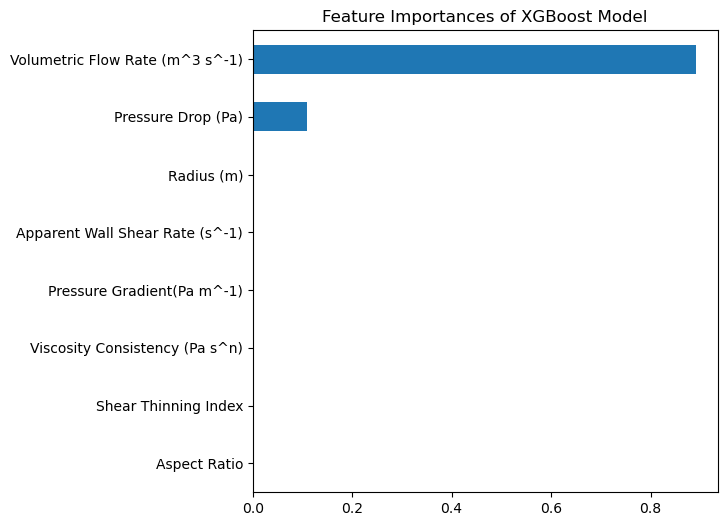

In [151]:
model_xgb, spearman, y_pred = run_xgboost(n_estimators=100, max_depth=3, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, X_test=X_test)
print(spearman.statistic, spearman.pvalue)

# Get the feature importances of the model
feature_importances= get_feature_importances(model_xgb, Theoretical_data.columns)

# Plot the feature importances
plot_feature_importances(feature_importances, title="Feature Importances of XGBoost Model")

(3430, 2)


In [156]:
#add a second column to the y_pred array as a place holder
y_pred = np.append(y_pred.reshape(-1,1), y_pred.reshape(-1,1), axis=1)

print(y_pred.shape)

In [158]:
print(y_test_total.shape)

(3430, 2)


In [161]:
#scale the target and predict values back to the original scale
X_test_unscaled = Xscaler.inverse_transform(X_test)
y_pred_unscaled = yscaler.inverse_transform(y_pred)
y_test_total_unscaled = yscaler.inverse_transform(y_test_total)


In [162]:
print(X_test_unscaled)
print(y_pred_unscaled)
print(y_test_total_unscaled)

[[2.50000000e-04 1.00000000e+01 1.66500000e+07 ... 7.59105525e-11
  6.70000000e-01 1.10000000e+03]
 [7.50000000e-04 3.00000000e+01 3.00150000e+09 ... 1.96103676e-07
  6.70000000e-01 1.10000000e+03]
 [5.00000000e-04 2.00000000e+01 2.07422222e+08 ... 4.73975382e-09
  6.70000000e-01 1.10000000e+03]
 ...
 [5.00000000e-04 2.00000000e+01 6.29888889e+08 ... 1.49598709e-08
  6.70000000e-01 1.10000000e+03]
 [2.50000000e-04 1.00000000e+01 1.22266667e+08 ... 5.50510887e-10
  6.70000000e-01 1.10000000e+03]
 [5.00000000e-04 2.00000000e+01 9.11533333e+08 ... 2.17430928e-08
  6.70000000e-01 1.10000000e+03]]
[[8.24051244e-11 1.58700754e-12]
 [1.93456117e-07 4.41239223e-09]
 [4.63316585e-09 1.05388705e-10]
 ...
 [1.47150887e-08 3.35354827e-10]
 [4.74258577e-10 1.05250851e-11]
 [2.13423235e-08 4.86520324e-10]]
[[6.79520604e-11 7.95849207e-12]
 [1.93673704e-07 2.42997148e-09]
 [4.71942944e-09 2.03243781e-11]
 ...
 [1.47131420e-08 2.46728869e-10]
 [4.99579418e-10 5.09314688e-11]
 [2.13857625e-08 3.5733026

In [163]:
Q_slip_pred = X_test_unscaled[:,5]-y_pred_unscaled[:,0]



In [164]:
#add the calculated slip values to the unscaled predictions
y_pred_unscaled[:,1] = Q_slip_pred

IndexError: index 1 is out of bounds for axis 1 with size 1

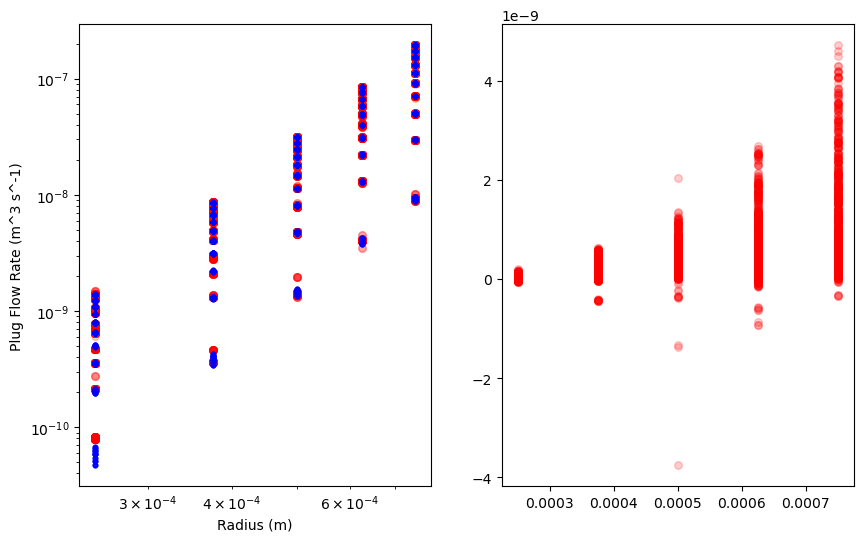

In [80]:
for k in range(len(Theoretical_data.columns)):
    fig, axs = plt.subplots(1, y_pred_unscaled.shape[1], figsize=(10, 6))
    for i in range(y_pred_unscaled.shape[1]):
        axs[i].scatter(X_test_unscaled[:, k], y_pred_unscaled[:, i], alpha = 0.2, label = 'Predicted', color = 'red', s=30)
        axs[i].scatter(X_test_unscaled[:, k], y_test_total_unscaled[:,i], alpha = 0.3, label = 'Calculated', color = 'blue', s=10)
        axs[i].set_ylabel(Target_Values.columns[i])
        axs[i].set_xlabel(Theoretical_data.columns[k])
        axs[i].set_yscale('log')
        axs[i].set_xscale('log')
    fig.suptitle(['Predicted (red) vs Calculated(blue) against', Theoretical_data.columns[k]])